In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve, auc
import pandas as pd
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing 

In [2]:
# Read in data 
data = pd.read_csv('rdp5_data.csv', na_values=['NS'])
# data = data.fillna(-1)

# Split data into training and testing sets 
X = data.drop(columns=['Label'])
y = data.Label

# # Keep only rows where multiple methods detected a signal 
# rows = X.count(1) > 1
# X = X[rows].fillna(-1)
# y = y[rows]

# Scale the data 
x = X.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=X.columns)

# Create feature based on the standard deviation of the row 
std = X.std(axis=1, numeric_only=True)

# Create feature based on number of counts 
X['Method Count'] = X.count(1)
X['Row Std'] = std

# Change NS 
X = X.fillna(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [3]:
"""
Bagged decision tree 
"""
# Fit a bagged decision tree to the data 
bag_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, n_jobs=-1, random_state=1)
bag_model.fit(X_train, y_train)

# Make predictions with bagged decision tree model 
bag_y_pred = bag_model.predict(X_test)


In [4]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

# Define the scorer 
sc = make_scorer(accuracy_score)

# Validate the model 
cross_validation_scores = cross_val_score(bag_model, X_train, y_train, cv=kf, scoring=sc)
print("Cross validation accuracy: {}".format(cross_validation_scores.mean()))


Cross validation accuracy: 0.6342368742368742


In [5]:
"""
Random forest tree with max_features 
"""

# Fit a random forest model with max_features = 1 to the data 
rf_mf1_model = RandomForestClassifier(n_estimators=750,              # Number of trees to train
                                      criterion="gini", 
                                      min_samples_leaf=1,        # Minimum samples in a leaf
                                      max_features=1,             # Maximum number of features per split 
                                      min_impurity_decrease=0,  # Minimum impurity decrease. 
                                      oob_score=False,                
                                      n_jobs=-1,                     # Parallel processing
                                      verbose=1,                     
                                      class_weight="balanced",
                                      random_state=1)           
rf_mf1_model.fit(X_train, y_train)

# Make predictions with random forest model with max_features = 1 
rf_mf1_y_pred = rf_mf1_model.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 750 out of 750 | elapsed:    0.1s finished


In [6]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

# Define the scorer 
sc = make_scorer(accuracy_score)

# Validate the model 
cross_validation_scores = cross_val_score(rf_mf1_model, X_train, y_train, cv=kf, scoring=sc)
print("Cross validation Accuracy: {}".format(cross_validation_scores.mean()))


# Training loss 
rf_mf1_y_pred = rf_mf1_model.predict(X_train)
rf_mf1_accuracy = accuracy_score(y_train, rf_mf1_y_pred)
print("Training Accuracy: {}".format(rf_mf1_accuracy))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 750 out of 750 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tas

Cross validation Accuracy: 0.6584859584859586
Training Accuracy: 0.9911894273127754


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 750 out of 750 | elapsed:    0.2s finished


In [7]:
"""
XGboost model 
"""
# Fit an XGboost model to the data 
XGB_model = XGBClassifier(max_depth=3,                 
                          learning_rate=0.01,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                          n_estimators=250,            # Number of trees to use
                          objective='binary:logistic',  # Type of target variable.
                          booster='gbtree',             # Boosting trees 
                          n_jobs=-1,                    # Parallelization 
                          gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                          reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                          reg_lambda=1,                 # Regularizer for first fit.
                          random_state=1
                         )

XGB_model.fit(X_train, y_train)

# Make predictions with the XGB model  
XGB_model_y_pred = XGB_model.predict(X_test)
    

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

# Define the scorer 
sc = make_scorer(accuracy_score)

# Validate the model 
cross_validation_scores = cross_val_score(XGB_model, X_train, y_train, cv=kf, scoring=sc)
print("Cross validation accuracy: {}".format(cross_validation_scores.mean()))

XGB_model_y_pred = XGB_model.predict(X_train)
XGB_accuracy = accuracy_score(y_train, XGB_model_y_pred)
print("Training Accuracy: {}".format(XGB_accuracy))


Cross validation accuracy: 0.6452014652014653
Training Accuracy: 0.762114537444934


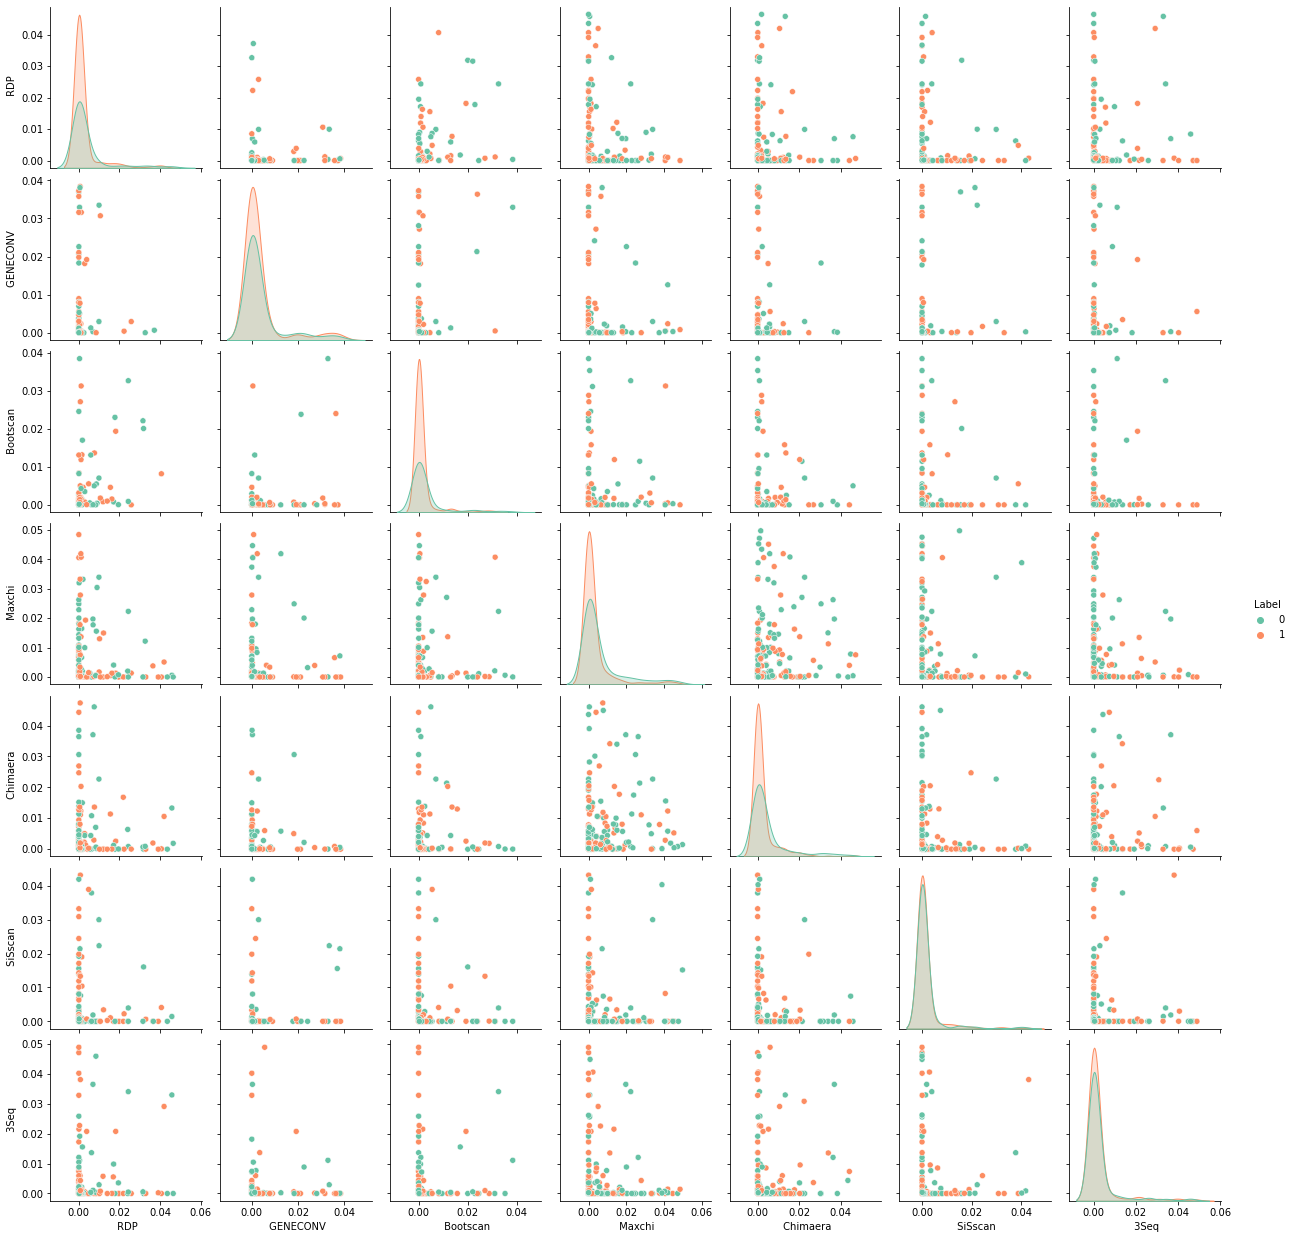

In [9]:
# Visualizing class separation 
g = sns.pairplot(data, hue="Label", palette="Set2", diag_kind="kde")

In [10]:
# TP: true postives 
# TN: true negatives 
# FP: False positives 
# FN: False negatives
def compute_performance(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    # Print results
    print("Accuracy:",round(acc,3),
          "\nRecall:",round(recall,3),
          "\nPrecision:",round(precision,3),
          "\nSensitivity:",round(sensitivity,3),
          "\nSpecificity:",round(specificity,3))
        
    # Calculate f-measure 
    if precision > 0 or recall > 0:
        f_measure = 2 * (precision * recall) / (precision + recall) 
        
    else:
        f_measure = 0
    
        
    # Calculate balanced accuracy
    balanced_accuracy = 0.5 * (sensitivity + specificity)             # Balanced accuracy 
    print("F-measure: {}\nBalanced accuracy: {}\n".format(f_measure, balanced_accuracy))
    
    return 

In [22]:
def show_performance(model):
    y_test_proba = model.predict_proba(X_test)

    # Set the threshold of the classifier to 50%
    yhat = model.classes_[(y_test_proba[:, 1] > 0.5).astype(int)]

    # Make predictions 
    compute_performance(yhat, y_test, model.classes_)

    # ROC model 
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:,1], pos_label=1)  
    
    # ROC RDP5 
    proba_rdp = np.ones(y_test.shape) #RDP always predicts true for the data 
    fpr_RDP, tpr_RDP, _ = roc_curve(y_test, proba_rdp, pos_label=1) 

    # AUROC for Amount-only classifier
    model_auc = auc(fpr, tpr)
    rdp5_auc = auc(fpr_RDP, tpr_RDP)

    # Plot the data
    plt.plot(fpr, tpr, label = '(Model AUROC = %0.3f)' % model_auc)
    plt.plot(fpr_RDP, tpr_RDP, label = 'RDP5 AUROC = %0.3f' % rdp5_auc)
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')

    plt.legend(loc = 'lower right')
    plt.show()
    
    # PRC for all-variable classifier
    precision, recall, threshold = precision_recall_curve(y_test, y_test_proba[:,1], pos_label=1)

    # AUROC for all-variable classifier
    auprc = auc(recall, precision)

    # Plot the data
    plt.plot(recall, precision, label = '(AUPRC = %0.3f)' % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PRC')

    plt.legend()
    plt.show()

In [25]:
# show_performance(XGB_model)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 750 out of 750 | elapsed:    0.1s finished


tp: 39 tn: 36 fp: 28 fn: 11
Accuracy: 0.658 
Recall: 0.78 
Precision: 0.582 
Sensitivity: 0.78 
Specificity: 0.562
F-measure: 0.6666666666666667
Balanced accuracy: 0.67125



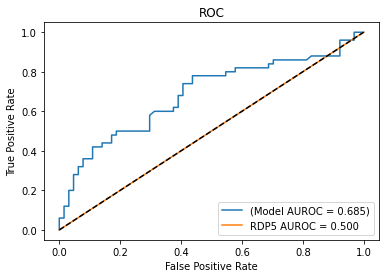

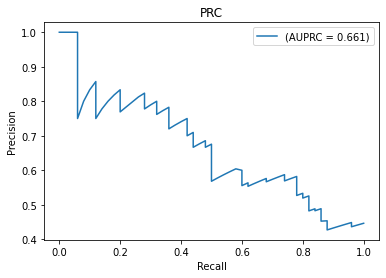

In [24]:
show_performance(rf_mf1_model)